# Pairs Trading Strategy - explanation and development by Lucas Lara

Pairs trading is a form of mean-reversion that has a distinct advantage of always being hedged against market movements. It is generally a high alpha strategy when backed up by some rigorous statistics. The strategy is based on mathematical analysis.

The prinicple is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it.

In [ ]:
# Some packages you'll need for this strategy (if does not run, remember to install the package via pip first)

import numpy as np
import pandas as pd
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

: 

## Necessary concepts

I will now explain concepts that serve as the basis of the Paris Trading strategy, so that the more technical definition below is understandable.

### Stationarity/Non-Stationarity

Stationarity is the most common unproven assumption in time series analysis. If the parameters of the data generation process do not change over time, we generally assume that the data are stationary. Consider two additional series: A and B. Series A will form a stationary time series with fixed parameters, while B will vary over time.
 
We create a function that determines the z-score (a way of measuring how much a data deviates from the mean of a data set in terms of standard deviations) of the probability density function. The probability density for a Gaussian distribution is:

$$ p(x) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}$$

$\mu$ is the mean and $\sigma$ is the standard deviation. The square of the standard deviation, $\sigma^{2}$, is the variance. The empircal rule dictates that 66% of the data should be somewhere between $x+\sigma$ and $x-\sigma$,which implies that the function `numpy.random.normal` is more likely to return samples lying close to the mean, rather than those far away.

In [20]:
 def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

From there, we can create two plots that exhibit a stationary and non-stationary time series.

Text(0.5, 1.0, 'Non-Stationary')

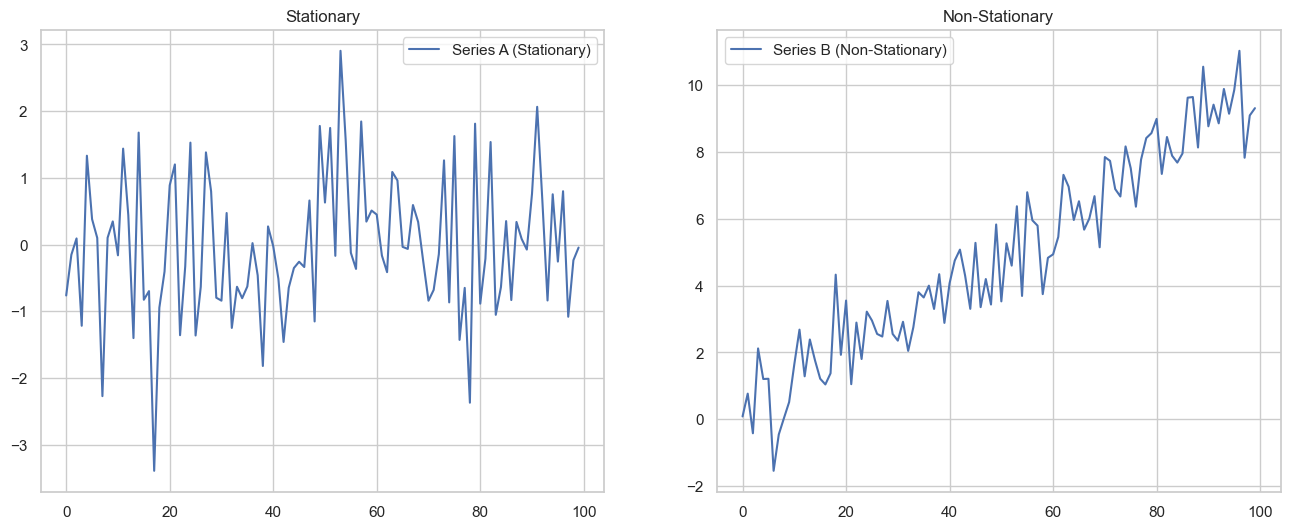

In [21]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)

T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_data(params)
    
fig, (ax1, ax2) = plt.subplots(nrows =1, ncols =2, figsize=(16,6))

ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A (Stationary)'])
ax2.legend(['Series B (Non-Stationary)'])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')

### Why Stationarity is Important

Many statistical test require that the data being tested are stationary. Using certain statistics on a non-stationary data set may lead to garbage results. As an example, let's take an average through our non-stationary $B$.

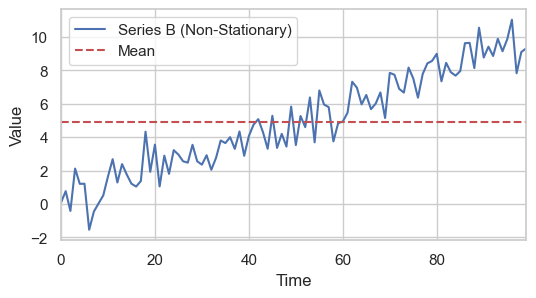

In [22]:
mean = np.mean(B)

plt.figure(figsize=(6,3))
plt.plot(B)
plt.hlines(mean, 0, len(B), linestyles='dashed', colors = 'r')
plt.xlabel('Time')
plt.xlim([0, 99])
plt.ylabel('Value')
plt.legend(['Series B (Non-Stationary)', 'Mean'])

The computed mean will show that the mean of all data points, but won't be useful for any forecasting of future state. It's meaningless when compared with any specific time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can distort the analysis, much more subtle problems can arise in practice.

#### Augmented Dickey Fuller (ADF)

In order to test for stationarity, we need to test for something called a *unit root*. Autoregressive unit root test are based the following hypothesis test:

$$
\begin{aligned}
H_{0} & : \phi =\ 1\ \implies y_{t} \sim I(0) \ | \ (unit \ root) \\
H_{1} & : |\phi| <\ 1\ \implies y_{t} \sim I(0) \ | \ (stationary)  \\
\end{aligned}
$$

It's referred to as a unit root test because under the null hypothesis, the autoregressive polynomial of $z_{t}, \phi_{z} = (1 - \phi_{z}) = 0 $,has a root equal to unity.


$y_{t}$ is trend stationary under the null hypothesis. If $y_{t}$is then first differenced, it becomes:

\begin{aligned}
\Delta y_{t} & = \delta + \Delta\mathcal{z}_{t} \\
\Delta \mathcal{z}_{t} & = \phi\Delta\mathcal{z}_{t-1} + \varepsilon_{t} - \varepsilon_{t-1}
\end{aligned}

The test statistic is

$$ t_{\phi=1}=\frac{\hat{\phi}-1}{SE(\hat{\phi})}$$

$\hat{\phi}$ is the least square estimate and SE($\hat{\phi}$) is the usual standard error estimate. The test is a one-sided left tail test. If {$y_{t}$} is stationary, then it can be shown that

$$\sqrt{T}(\hat{\phi}-\phi)\xrightarrow[\text{}]{\text{d}}N(0,(1-\phi^{2}))$$

or 

$$\hat{\phi}\overset{\text{A}}{\sim}N\bigg(\phi,\frac{1}{T}(1-\phi^{2}) \bigg)$$

andit follows that $t_{\phi=1}\overset{\text{A}}{\sim}N(0,1).$ However, under the null hypothesis of non-stationarity, the above result gives

$$
\hat{\phi}\overset{\text{A}}{\sim} N(0,1)
$$

The following function will allow us to check for stationarity using the Augmented Dickey Fuller (ADF) test.

In [23]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [24]:
stationarity_test(A)
stationarity_test(B)

p-value = 9.906337562764173e-18 The series A is likely stationary.
p-value = 0.8448031486507108 The series B is likely non-stationary.


As we can see, based on the test statistic (which correspnds with a specific p-value) for time series A, we can fail to reject the null hypothesis. As such, Series A is likely to be  stationary. On the other hand, Series B is rejected by the hypothesis test, so this time series is likely to be non-stationary.

### Cointegration

The correlations between financial quantities are notoriously unstable. Nevertheless, correlations are regularly used in almost all multivariate financial problems. An alternative statistical measure to correlation is cointegration. This is probably a more robust measure of linkage between two financial quantities, but as yet there is little derviaties theory based on this concept.

Two stocks may be perfectly correlated over short timescales, yet diverge in the long run, with one growing and the other decaying. Conversely, two stocks may follow each other, never being more than a certain distance apart, but with any correlation, positive negaative or varying. If we are delta hedging, then maybe the short timescale orrelation matters, but not if we are holding stocks for a long time in an unhedged portfolio.

We've constructed an example of two cointegrated series. We'll plot the difference between the two now so we can see how this looks.

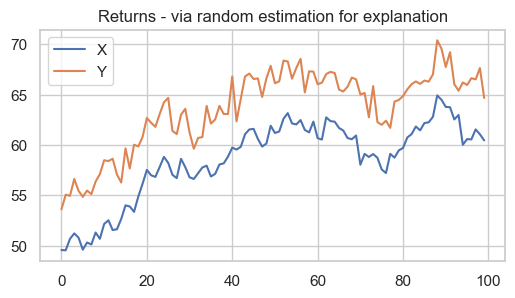

In [25]:
# Generate daily returns

Xreturns = np.random.normal(0, 1, 100)

# sum up and shift the prices up

X = pd.Series(np.cumsum(
    Xreturns), name='X') + 50

noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X, Y], axis=1).plot(figsize=(6, 3))

plt.title('Returns - via random estimation for explanation')
plt.show()

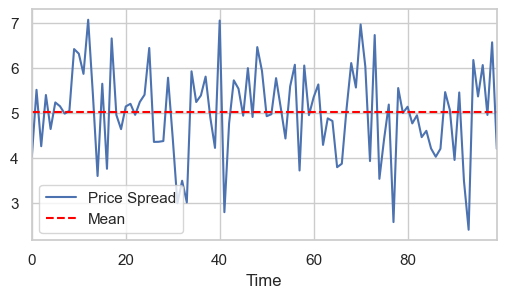

In [26]:
plt.figure(figsize=(6,3))
(Y - X).plot() # Plot the spread
plt.axhline((Y - X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.xlim(0,99)
plt.legend(['Price Spread', 'Mean']);

#### Testing for Cointegration

The steps in the cointegration test procdure:

1. Test for a unit root in each component series $y_{t}$ individually, using the univariate unit root tests, say ADF, PP test.
2. If the unit root cannot be rejected, then the next step is to test cointegration among the components, i.e., to test whether $\alpha Y_{t}$ is I(0).

If we find that the time series as a unit root, then we move on to the cointegration process. There are three main methods for testing for cointegration: Johansen, Engle-Granger, and Phillips-Ouliaris. We will primarily use the Engle-Granger test.

Let's consider the regression model for $y_{t}$:

$$y_{1t} = \delta D_{t} + \phi_{1t}y_{2t} + \phi_{m-1} y_{mt} + \varepsilon_{t} $$

$D_{t}$ is the deterministic term. From there, we can test whether $\varepsilon_{t}$ is $I(1)$ or $I(0)$. The hypothesis test is as follows:

$$
\begin{aligned}
H_{0} & :  \varepsilon_{t} \sim I(1) \implies y_{t} \ (no \ cointegration)  \\
H_{1} & : \varepsilon_{t} \sim I(0) \implies y_{t} \ (cointegration)  \\
\end{aligned}
$$

$y_{t}$ is cointegrated with a *normalized cointegration vector* $\alpha = (1, \phi_{1}, \ldots,\phi_{m-1}).$

We also use residuals $\varepsilon_{t}$ for unit root test.

$$
\begin{aligned}
H_{0} & :  \lambda = 0 \ (Unit \ Root)  \\
H_{1} & : \lambda < 1 \ (Stationary)  \\
\end{aligned}
$$

This hypothesis test is for the model:

$$\Delta\varepsilon_{t}=\lambda\varepsilon_{t-1}+\sum^{p-1}_{j=1}\varphi\Delta\varepsilon_{t-j}+\alpha_{t}$$

The test statistic for the following equation:

$$t_{\lambda}=\frac{\hat{\lambda}}{s_{\hat{\lambda}}} $$

Now that you understand what it means for two time series to be cointegrated, we can test for it and measure it using python:

In [27]:
score, pvalue, _ = coint(X,Y)
print(pvalue)

# Low pvalue means high cointegration!

2.3975714938175963e-15


#### Correlation vs. Cointegration

Correlation and cointegration, while theoretically similiar, are anything but similiar. To demonstrate this, we can look at examples of two time series that are correlated, but not cointegrated.

A simple example is two series that just diverge.

(0.0, 99.0)

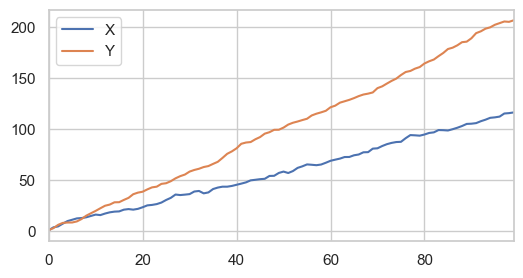

In [28]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')


pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(6,3));
plt.xlim(0, 99)


Next, we can print the correlation coefficient, $r$, and the cointegration test 

In [29]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.9981477374244969
Cointegration test p-value: 0.01581998506585401


As we can see, there is a very strong (nearly perfect) correlation between series X and Y. However, our p-value for the cointegration test yields a result of 0.1181, which means there is no cointegration between time series X and Y.

Another example of this case is a normally distributed series and a sqaure wave.

Correlation: 0.05148413380334506
Cointegration test p-value: 0.0


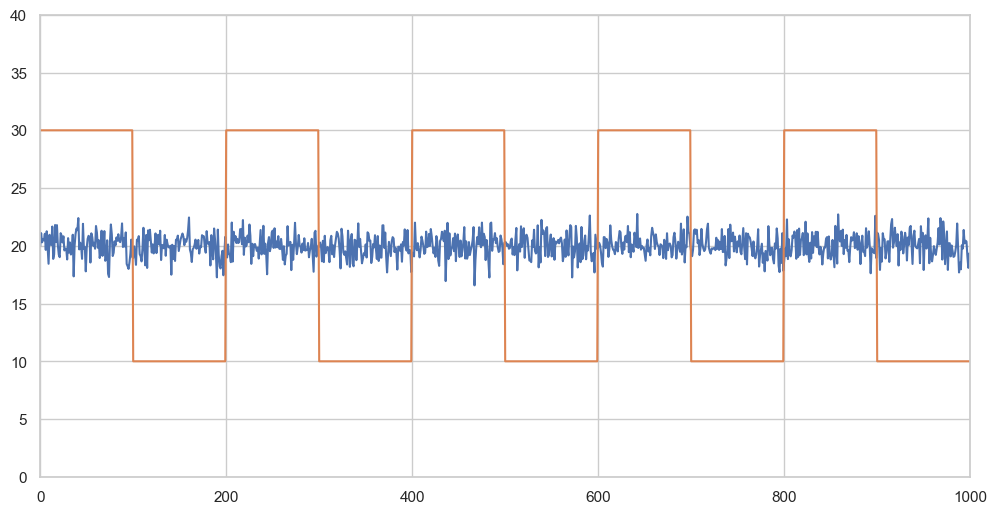

In [30]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10


plt.figure(figsize=(12,6))
Y2.plot()
Y3.plot()
plt.ylim([0, 40])
plt.xlim([0, 1000]);

# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue))

Although the correlation is incredibly low, the p-value shows that these time series are cointegrated.

In [31]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
from datetime import datetime
import datetime
import yfinance as yf
yf.pdr_override()

Now that we know the basics, we can move on to the strategy itself.

## Pairs Trading Strategy

To begin with, we will work as an example with 2 shares of Chilean companies.

In [32]:
from datetime import datetime
import yfinance as yf

start = datetime(2015, 1, 1)
end = datetime(2023,1,1)

y, x = "COPEC.SN", "CMPC.SN"

data = yf.download([y, x], start=start, end=end, progress=False)["Adj Close"]
data.columns = ["COPEC.SN", "CMPC.SN"]


We are looking through a set of tech companies to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security from the year 2018 until today's date.

As mentioned before, we have formulated an economic hypothesis that there is some sort of link between a subset of securities within the tech sector and we want to test whether there are any cointegrated pairs. This incurs significantly less multiple comparisons bias than searching through hundreds of securities and slightly more than forming a hypothesis for an individual test.

We will use the portfolio tickets used in my LinkedIn publication on PORTFOLIO - Basics in which I briefly explain how to diversify a portfolio using non-correlated assets to reduce risk. (If you don't see it yet: https://www.linkedin.com/feed/update/urn:li:activity:7158942145746231297/)

In [33]:
tickers = ["COPEC.SN", "CMPC.SN"]

df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  2 of 2 completed


,CMPC.SN,COPEC.SN
Date,,
2022-12-26,1420.300049,6300.0
2022-12-27,1391.900024,6306.0
2022-12-28,1385.000000,6400.0
2022-12-29,1400.000000,6300.0
2022-12-30,1415.900024,6329.0


Now we check the correlation and cointegration based on their cummulative returns.

In [34]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

returns = data.pct_change().dropna()
correlation = returns.corr()

print("Correlation between returns:")
print(correlation)

cointegration_test = coint(returns.iloc[:, 0], returns.iloc[:, 1])
p_value = cointegration_test[1]

print("\nP-value of cointegration test:", p_value)


Correlation between returns:
          COPEC.SN   CMPC.SN
COPEC.SN  1.000000  0.645404
CMPC.SN   0.645404  1.000000



P-value of cointegration test: 0.0


As the p-value of the cointegration test is less than 0.01 (by far!) if they are cointegrated, we can work with COPEC and CMPC.

We now perform for the two actions a linear regression of the form:

$$ Y = \beta X + \varepsilon $$

In [35]:
import plotly.express as px
# Now we'll work based on their cummulative returns

cumulative_returns = (1 + returns). cumprod() - 1
fig = px.line(100*cumulative_returns, title = "Cumulative Returns")
fig. show()

We now perform for the two stocks a linear regression of the form:
$$ Y = \beta X + \varepsilon $$

In [36]:
# Linear regresion input

ratio = data["COPEC.SN"]/data["CMPC.SN"]
fig = px.line(ratio, title='Ratio COPEC/CMPC')
fig.show()

In [37]:
# Linear regresion excercise:

Y = data['COPEC.SN']
X = data['CMPC.SN']
model = sm.OLS(Y, X).fit()
beta_hat = model.params.iloc[0]
print('beta hat =', beta_hat)

residuals = Y - beta_hat*X
print('residuals =', residuals)

fig = px.line(residuals)
fig.show()

fig2 = px.histogram(residuals)
fig2.show()

beta hat = 0.22899030464181883
residuals = Date
2015-01-02   -154.748963
2015-01-05   -149.766699
2015-01-06   -156.943947
2015-01-07   -142.889489
2015-01-08   -130.369516
                 ...    
2022-12-26    -22.430924
2022-12-27    -52.201239
2022-12-28    -80.624267
2022-12-29    -42.728410
2022-12-30    -33.470722
Length: 1994, dtype: float64


In [38]:
from statsmodels.regression.rolling import RollingOLS

X = sm.add_constant(X) # Adding a constant to the independent variable (intercept)

lookback = 60
rolling = RollingOLS(Y, X, window=lookback).fit()
rolling_beta = rolling.params
rolling_beta = rolling_beta.bfill()

import plotly.express as px
fig = px.line(rolling_beta)
fig.show()


In [39]:
# Now the rolling residuals from the oher variable
rolling_residuals = Y - rolling_beta["CMPC.SN"] * X["CMPC.SN"]

rolling_residuals_df = pd.DataFrame(rolling_residuals, index=Y.index, columns=['Residuals'])

fig = px.line(rolling_residuals_df, title='Rolling Residuals for CMPC')
fig.show()


Now that we have found the linear regression, let's test its statistics to see if the data are significant in order to continue with the strategy in a safer and more accurate way.

In [40]:
test_df_copec = adfuller(residuals)
test_df_cmpc = adfuller(rolling_residuals)

print('Test statistic copec:', test_df_copec[0]) 
print('P-value copec:', test_df_copec[1]) 

print('Critical values copec:', test_df_copec[4])

print('Test statistic cmpc:', test_df_cmpc[0])
print('P-value cmpc:', test_df_cmpc[1]) 
print('Critical values cmpc:', test_df_cmpc[4])


Test statistic copec: -2.997247530814868
P-value copec: 0.035152247019703965
Critical values copec: {'1%': -3.4336403292634223, '5%': -2.862993486306054, '10%': -2.5675437746521554}
Test statistic cmpc: -6.594254861240803
P-value cmpc: 6.989600300209046e-09
Critical values cmpc: {'1%': -3.4336419856688276, '5%': -2.862994217611322, '10%': -2.567544164035933}


All statistics (p-value) indicate that they are significant!

### Z-Score

Regardless of whether or not we use the spread approach or the ratio approach, we can see that our first plot pair PPL/WMT tends to move around the mean. We now need to standardize this ratio because the absolute ratio might not be the most ideal way of analyzing this trend. For this, we need to use z-scores.

A statistical measure that quantifies how many standard deviations a specific data point is from the average of a data set (indicates whether a particular value is above or below the average in terms of variability).

$$ Z = \frac{{(X - \mu)}}{\sigma} $$

In [41]:
# Now we define the tresholds value

k=2 # Thresholds

In [42]:
z_score = (rolling_residuals - rolling_residuals.rolling(lookback).mean())/rolling_residuals.rolling(lookback).std()
fig = px.line(z_score, title = "Z-Score")
fig.add_hline(y=k, line_dash="dash", line_color="red", annotation_text="Upper Threshold", annotation_position="top right")
fig.add_hline(y=-k, line_dash="dash", line_color="green", annotation_text="Lower Threshold", annotation_position="bottom right")
fig.show()

By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

### Trading Signals

What's great about pair trading signals is that we don't need to know absolutes about where the prices will go, all we need to know is where it's heading: up or down.

When conducting any type of trading strategy, it's always important to clearly define and delineate at what point you will actually do a trade. As in, what is the best indicator that I need to buy or sell a particular stock? 

We're going to use the ratio time series that we've created to see if it tells us whether to buy or sell a particular moment in time. We'll start off by creating a prediction variable $Y$. If the ratio is positive, it will signal a "buy," otherwise, it will signal a sell. The prediction model is as follows:

$$Y_{t} = sign(Ratio_{t+1}-Ratio_{t}) $$

### When a Z-Score signal is triggered, what do I trade?

$$ Y = \beta X (spread) $$

Upper Threshold: Sell signal --> Sell Y, buy $\beta$ times X
Lower Threshold: Sell signal --> Buy Y, sell $\beta$ times X

This brings a problem: the $beta$ keeps changing. So every day you have to take a period of time and estimate the hedge.

This is becaus the rule of mean reversion, wich a standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the previous trading signals.

### Metrics

$ P\&L $: 

Profit and Loss is calculated by subtracting the initial cost of the trade (including commissions, fees, etc.) from the current value of the trade (the current market value of the open positions, also taking into account the commissions and fees associated with closing the positions). If the result is positive, it means that the trade has generated profits. If it is negative, it indicates that there has been a loss.

In [43]:
strategy_pnl = data["CMPC.SN"]
strategy_pnl_returns = strategy_pnl.pct_change().dropna()
strategy_pnl_cum_returns = (1 + strategy_pnl_returns).cumprod() - 1
fig = px.line(strategy_pnl_cum_returns)
fig.show()

$ Sharpe\ ratio $:

$$  SR = \frac{{R_p - R_f}}{{\sigma_p}}  $$ 

The Sharpe Ratio can be used to evaluate the profitability of the trading strategy relative to the risk taken. A higher Sharpe Ratio indicates a higher return compared to the risk taken, suggesting that the strategy is more efficient in terms of risk-adjusted return.

In [44]:
sharpe = strategy_pnl_returns.mean()*np.sqrt(252)/strategy_pnl_returns.std() # 252 días laborales, sharpe de CMPC
sharpe

0.13307266719031116

In [45]:
diff = data.diff()
positions = pd.DataFrame(0, columns = list(data.columns), index = data.index)
positions

,COPEC.SN,CMPC.SN
Date,,
2015-01-02,0,0
2015-01-05,0,0
2015-01-06,0,0
2015-01-07,0,0
2015-01-08,0,0
...,...,...
2022-12-26,0,0
2022-12-27,0,0
2022-12-28,0,0


Now we create a function get_signals which will tell me if I am present at a Threshold: buy and sell signals.

In [46]:
def get_signals(z_score, k):
    if z_score > k:
        return 1  # Sell signal
    elif z_score < -k:
        return -1  # Buy signal
    else:
        return 0  # No signal

Now we create a backtest function that will implement the strategy, which consists of selling the spread if it crosses the upper threshold (sell Y , buy β X) and buy the spread if it crosses the lower threshold. We are asked to create a function called backtest, which receives an initial amount to invest and returns the positions of each stock in the strategy.


DataFrame with Positions and Nominal Value:
            Positions  Nominal execution of exercise
Date                                                
2015-01-02          0                       0.000000
2015-01-05          0                       0.000000
2015-01-06          0                       0.000000
2015-01-07          0                       0.000000
2015-01-08          0                       0.000000
...               ...                            ...
2022-12-26         -1                      22.430924
2022-12-27         -1                      52.201239
2022-12-28         -1                      80.624267
2022-12-29         -1                      42.728410
2022-12-30         -1                      33.470722

[1994 rows x 2 columns]

Final Notional: $ 1006400.6381514075
Net Income: $ 6400.638151407475


/var/folders/d5/gq7zzf6j3lx9vmb_2npsfqxh0000gn/T/ipykernel_27804/1003495476.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



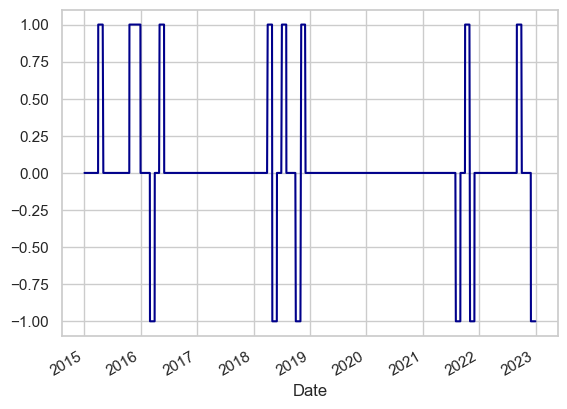

In [47]:
def backtest(notional, residuals, k):
    positions = pd.DataFrame(index=residuals.index)
    positions["Positions"] = 0
    positions["Nominal execution of exercise"] = 0
    capital = notional
    status = "Waiting"

    for month, data_month in residuals.groupby(residuals.index.to_period("M")):
        signal_month = 0

        for time in data_month.index:
            signal = get_signals(residuals.loc[time], k)

            if signal != 0:
                signal_month = signal

        for time in data_month.index:
            if signal_month != 0:
                if status == "Open Up" and signal_month == -1:  # Sell
                    positions.loc[time, "Positions"] = -1
                    capital += residuals.loc[time]  # Assuming we sell the residuals
                elif status == "Open Down" and signal_month == 1:  # Buy
                    positions.loc[time, "Positions"] = 1
                    capital -= residuals.loc[time]  # Assuming we buy the residuals
                else:
                    positions.loc[time, "Positions"] = 0
            else:
                positions.loc[time, "Positions"] = 0

            positions.loc[time, "Nominal execution of exercise"] = positions.loc[time, "Positions"] * residuals.loc[time]

        if data_month.iloc[-1] > k:
            status = "Open Up"
        elif data_month.iloc[-1] < -k:
            status = "Open Down"
        else:
            status = "Waiting"

    return positions, capital

# Example usage
notional = 1000000  # Notional to invest
k = 2  # Threshold for the Z-Score (adjust according to your strategy)
positions, final_notional = backtest(notional, residuals, k)

positions["Positions"].iloc[200:250] = 1  # Changed to 1 to represent "buy"
positions["Positions"].plot(color="darkblue")

# Print the DataFrame with positions and the nominal value
print("\nDataFrame with Positions and Nominal Value:")
print(positions)

print("\nFinal Notional: $", final_notional)

print("Net Income: $", final_notional - notional)


Finally we reflect the cumulative P&L of the whole strategy to see the performance

In [48]:
# Calculate PnL of the strategy
diff = data.diff()
daily_gain = positions["Positions"] * diff["CMPC.SN"]
cumulative_pnl = daily_gain.cumsum()

# Calculate metrics
strategy_pnl = data["CMPC.SN"]
strategy_pnl_returns = strategy_pnl.pct_change().dropna()
sharpe_ratio = strategy_pnl_returns.mean() * np.sqrt(252) / strategy_pnl_returns.std()  # 252 business days, CMPC's sharpe
max_drawdown = (cumulative_pnl / cumulative_pnl.cummax() - 1).min()
cvar = strategy_pnl_returns.quantile(0.05)

# Plot cumulative PnL
fig = px.line(cumulative_pnl, title="Cumulative PnL of the Strategy")
fig.show()

# Print metrics
print("Sharpe Ratio:", sharpe_ratio)
print("Max Drawdown:", max_drawdown)
print("CVaR:", cvar)


Sharpe Ratio: 0.13307266719031116
Max Drawdown: -23.49884064012297
CVaR: -0.02863318463887807


Despite the profit and Loss, it shows that the profit is positive, not bad for this strategy. However, as these two Chilean stocks are highly correlated (around 66%), the challenge is to look for another pair of stocks that are less correlated, so that the opposite movements (buy/sell) are more profitable.

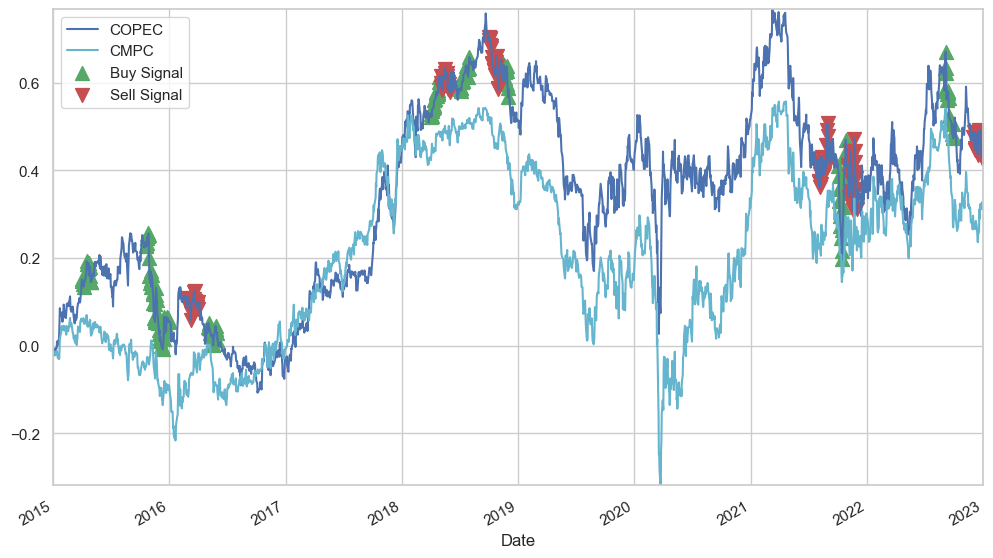

In [49]:
cumulative_returns_COPEC = data['COPEC.SN'].pct_change().cumsum()
cumulative_returns_CMPC = data['CMPC.SN'].pct_change().cumsum()

plt.figure(figsize=(12,7))

# Plot the cumulative returns of COPEC and CMPC
cumulative_returns_COPEC.plot(color='b')
cumulative_returns_CMPC.plot(color='c')

# Get the buy and sell dates
buy_dates = positions[positions['Positions'] == 1].index
sell_dates = positions[positions['Positions'] == -1].index

buy_dates = buy_dates[(buy_dates >= '2015-01-01') & (buy_dates <= '2023-01-01')]
sell_dates = sell_dates[(sell_dates >= '2015-01-01') & (sell_dates <= '2023-01-01')]

plt.scatter(buy_dates, cumulative_returns_COPEC.loc[buy_dates], color='g', label='Buy Signal', marker='^', s=100)
plt.scatter(sell_dates, cumulative_returns_COPEC.loc[sell_dates], color='r', label='Sell Signal', marker='v', s=100)

plt.ylim(min(cumulative_returns_COPEC.loc['2015-01-01':'2023-01-01'].min(), cumulative_returns_CMPC.loc['2015-01-01':'2023-01-01'].min()), 
         max(cumulative_returns_COPEC.loc['2015-01-01':'2023-01-01'].max(), cumulative_returns_CMPC.loc['2015-01-01':'2023-01-01'].max()))
plt.xlim('2015-01-01', '2023-01-01')

plt.legend(['COPEC', 'CMPC', 'Buy Signal', 'Sell Signal'])

plt.show()

Overall, this graph provides a visual representation of the cumulative returns of COPEC and CMPC, as well as the buy and sell signals generated by the pair trading strategy during the specified period

## Conclusion

Upon concluding this work on pair trading, we can affirm that we have explored an effective investment strategy based on analyzing the relationship between two correlated financial assets. Throughout our analysis, we have highlighted the importance of pair trading as a versatile tool for diversifying portfolios, managing risks, and seeking profit opportunities in the financial markets.

Key points addressed include:

##### Methodology of Pair Trading

We have detailed how pair trading works, from identifying pairs of correlated assets to implementing trading strategies based on these relationships.

##### Data Analysis

We have emphasized the importance of data analysis in pair trading, including the use of statistical tools and modeling techniques to identify trading opportunities.

#### Advantages and Challenges

We have discussed the advantages of pair trading, such as portfolio diversification and risk management, as well as challenges, such as the risk of overfitting and the need to constantly adjust trading strategies.

#### Additional

We have concluded our work by summarizing key findings and providing recommendations for investors interested in exploring pair trading, such as the importance of thorough research and ongoing market analysis.

In summary, this work has provided a comprehensive insight into pair trading as an effective investment strategy and has equipped readers with a solid understanding of how to implement this strategy in their own trading operations.


## Areas of Improvement and Further Steps

This is by no means a perfect strategy and the implementation of our strategy isn't the best. However, there are several things that can be improved upon.

### 1. Using more securities and more varied time ranges

For the pairs trading strategy cointegration test, I only used a handful of stocks. Naturally (and in practice) it would be more effective to use clusters within an industry. I only use the time range of only 5 years, which may not be representative of stock market volatility.

### 2. Dealing with overfitting

Anything related to data analysis and training models has much to do with the problem of overfitting. There are many different ways to deal with overfitting like validation, such as Kalman filters, and other statistical methods.

### 3. Adjusting the trading signals

Our trading algorithm fails to account for stock prices that overlap and cross each other. Considering that the code only calls for a buy or sell given its ratio, it doesn't take into account which stock is actually higher or lower.

### 4. More advanced methods

This is just the tip of the iceberg of what you can do with algorithmic pairs trading. It's simple because it only deals with moving averages and ratios. If you want to use more complicated statistics, feel free to do so. Other complex examples include subjects such as the Hurst exponent, half-life mean reversion, and Kalman Filters.
